# Metric Learning with Stochastic Gradient Descent

In [149]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import decomposition
from sklearn import metrics
import itertools

## Loading and visualizing data

In [150]:
bool_iris = False

if bool_iris:  # use iris
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
else:  # use digits
    digits = datasets.load_digits()
    X = digits.data
    y = digits.target

    # on ne garde que les 7 premieres classes par simplicite
    X = X[y < 7]
    y = y[y < 7]

# standardize data
X -= X.mean(axis=0)
X /= X.std(axis=0)
X[np.isnan(X)] = 0.


def plot_2d(X, y):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    plt.figure()
    symlist = ['o', 's', '*', 'x', 'D', '+', 'p', 'v', 'H', '^']
    collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
               'fuchsia']

    labs = np.unique(y)
    idxbyclass = [y == labs[i] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.plot(X[idxbyclass[i], 0], X[idxbyclass[i], 1], '+',
                 color=collist[i % len(collist)], ls='None',
                 marker=symlist[i % len(symlist)])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.show()


/home/romain/installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/romain/installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


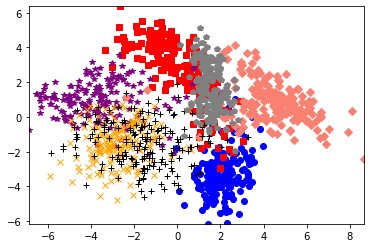

In [151]:
# on utilise PCA pour projeter les donnees en 2D
pca = decomposition.PCA(n_components=2)
X_2D = pca.fit_transform(X)
plot_2d(X_2D, y)

## Approche basée sur les paires

### Question 1

Donner ici l'interprétation de la fonction de perte.

La fonction de perte mesure l'erreur de classification, pénalisant d'avantage une distance plus grande lorsque les points sont semblables, et et pénalisant moins les grandes distances lorsque les points sont différents.

### Question 2

Compléter la fonction `sgd_metric_learning_pairs`. Vous n'avez qu'à ajouter le calcul du sous-gradient de la perte sur la paire tirée aléatoirement.

In [152]:
def psd_proj(M):
    """ projection de la matrice M sur le cone des matrices semi-definies
    positives"""
    # calcule des valeurs et vecteurs propres
    eigenval, eigenvec = np.linalg.eigh(M)
    # on trouve les valeurs propres negatives ou tres proches de 0
    ind_pos = eigenval > 1e-10
    # on reconstruit la matrice en ignorant ces dernieres
    M = np.dot(eigenvec[:, ind_pos] * eigenval[ind_pos][np.newaxis, :],
               eigenvec[:, ind_pos].T)
    return M


def hinge_loss_pairs(X, pairs_idx, y_pairs, M):
    """Calcul du hinge loss sur les paires
    """
    diff = X[pairs_idx[:, 0], :] - X[pairs_idx[:, 1], :]
    return np.maximum(0., 1. + y_pairs.T * (np.sum(np.dot(M, diff.T) * diff.T,
                                                   axis=0) - 2.))


def sgd_metric_learning_pairs(X, y, gamma, alpha, n_iter, n_eval, M_ini,
                              random_state=42):
    """Stochastic gradient algorithm for metric learning with pairs

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape

    # tirer n_eval paires aleatoirement
    # attention: celles-ci sont seulement utilisees pour evaluer la fonction objective
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires d'evaluation
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx, y_pairs, M))
        gradient = np.zeros((n_features, n_features))

        # on tire 1 paire
        pair_for_gradient = rng.randint(0, n_samples, 2)
        
        # TODO QUESTION 2
        xi = X[pair_for_gradient[0]]
        xj = X[pair_for_gradient[1]]
        yij = 2.0 * (y[pair_for_gradient[0]] == y[pair_for_gradient[1]]) - 1.0
        xi_xj = xi - xj
        if 1 + yij * (np.dot(np.dot(xi_xj, M), xi_xj) - 2) > 0:
            gradient = yij * np.outer(xi_xj, xi_xj)

        M -= gamma_func(t) * gradient
        M = psd_proj(M)
        
    return M, pobj

### Question 3

Tester l'algorithme sur Iris et Digits en adaptant le pas et le nombre d'itérations afin de le faire converger.

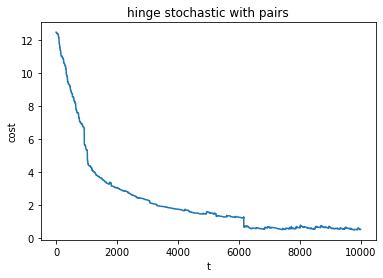

Nb de valeurs propres de M égales à 0:  3 / 64


In [153]:
n_features = X.shape[1]

# gamma (base value is 0.002)
gamma = 0.002

M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_pairs(X, y, gamma, 0.0, 10000, 1000, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M égales à 0: ", np.sum(e < 1e-12), "/", e.shape[0])

### Question 4

Utiliser le code ci-dessous plus transformer les données et comparer visuellement les représentations en dimension 2.

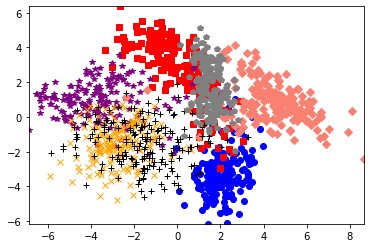

In [154]:
# calcul de la factorisation de cholesky
# on ajoute de tres faibles coefficients sur la diagonale pour eviter
# les erreurs numeriques
L = np.linalg.cholesky(M + 1e-10 * np.eye(n_features))
# on projette lineairement les donnees
X_proj = np.dot(X, L)

# TODO QUESTION 4: projeter X_proj en 2D avec une PCA

# on fait un plot du set original pour comparer
plot_2d(X_2D, y)

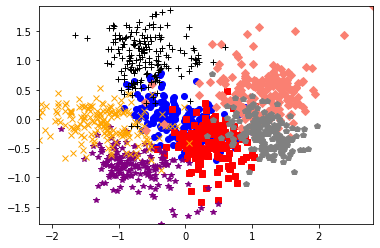

In [155]:
# on utilise PCA pour projeter les donnees en 2D
pca = decomposition.PCA(n_components=2)
X_proj_2D = pca.fit_transform(X_proj)
# plot des données projetées en 2D
plot_2d(X_proj_2D, y)

### Question 5

Pour un échantillon aléatoire de paires d’apprentissage, calculer les valeurs de distance et comparer la courbe ROC de la distance apprise avec celle de la distance Euclidienne. Calculer également l’aire sous la courbe ROC (AUC).

In [156]:
def distances_random_pairs(X, y, M, n_pairs=10000, random_state=42):
    """Draw random pairs and compute their Euclidean and Mahalanobis distance

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    M : array, shape (n_features, n_features)
        The matrix parameter of the Mahalanobis distance.
    n_pairs : int
        The number of pairs to sample
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    pairs = rng.randint(0, n_samples, (n_pairs, 2)) # tirer n_pairs paires aleatoires
    y_pairs = 2.0 * (y[pairs[:, 0]] == y[pairs[:, 1]]) - 1.0
    diff = X[pairs[:, 0], :] - X[pairs[:, 1], :]
    dist_euc = np.sqrt(np.sum(diff ** 2, axis=1))
    dist_M = np.sum(np.dot(M, diff.T) * diff.T, axis=0)
    return y_pairs, dist_euc, dist_M

AUC with Euclidian is 0.7870587970079002
AUC with M is 0.899213659517698


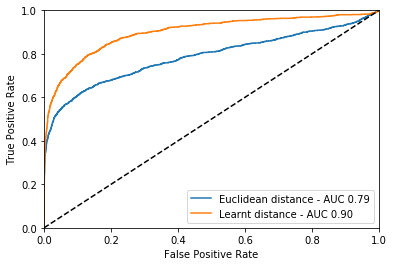

In [157]:
# on tire 10000 paires aleatoires et on calcule les distances
y_pairs, dist_euc, dist_M = distances_random_pairs(X, y, M, n_pairs=10000)

# tracer les courbes ROC
from sklearn.metrics import roc_curve, auc
# TODO QUESTION 5


fpr_euc, tpr_euc, _ = roc_curve(y_pairs, -dist_euc)
fpr_M, tpr_M, _ = roc_curve(y_pairs, -dist_M)

auc_euc = auc(fpr_euc, tpr_euc)
auc_M = auc(fpr_M, tpr_M)
# print area under curve
print("AUC with Euclidian is " + str(auc_euc))
print("AUC with M is " + str(auc_M))

# plot ROC curves

plt.figure()
plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Question 6

Modifier la fonction `sgd_metric_learning_pairs` pour permettre une version mini-batch de l'algorithme. Explorer l'effet sur la convergence de l'algorithme.

In [158]:
def sgd_metric_learning_batch(X, y, gamma, alpha, n_iter, n_eval, M_ini, batch_size, 
                              random_state=42):
    """Stochastic gradient algorithm for metric learning with pairs

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    batch_size : int
        The size of each mini-batch
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape

    # tirer n_eval paires aleatoirement
    # attention: celles-ci sont seulement utilisees pour evaluer la fonction objective
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires d'evaluation
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx, y_pairs, M))
        gradient = np.zeros((n_features, n_features))
        
        # on boucle sur la taille du batch
        for batch_element in range(batch_size):
            # on tire 1 paire
            pair_for_gradient = rng.randint(0, n_samples, 2)
            xi = X[pair_for_gradient[0]]
            xj = X[pair_for_gradient[1]]
            yij = 2.0 * (y[pair_for_gradient[0]] == y[pair_for_gradient[1]]) - 1.0
            xi_xj = xi - xj
            if 1 + yij * (np.dot(np.dot(xi_xj, M), xi_xj) - 2) > 0:
                gradient += yij * np.outer(xi_xj, xi_xj)
                
        gradient /= batch_size
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
        
    return M, pobj

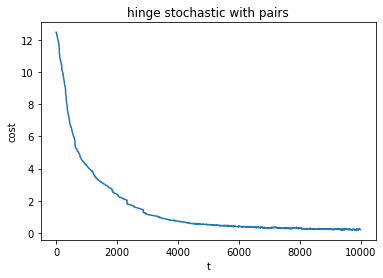

Nb de valeurs propres de M égales à 0:  3 / 64


In [159]:
n_features = X.shape[1]

# gamma (base value is 0.002)
gamma = 0.002
# batch size
batch_size = 10

M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_batch(X, y, gamma, 0.0, 10000, 1000, M_ini, batch_size)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M égales à 0: ", np.sum(e < 1e-12), "/", e.shape[0])

In [160]:

#  AIDE POUR LE BONUS DE LA QUESTION 6:

# def combs(a, r):
#     """ compute all r-length combinations of elements in array; a faster
#     than np.array(list(itertools.combinations(a, r)))
#     """
#     a = np.asarray(a)
#     dt = np.dtype([('', a.dtype)] * r)
#     b = np.fromiter(itertools.combinations(a, r), dt)
#     return b.view(a.dtype).reshape(-1, r)


### Question 7

Modifier la fonction `sgd_metric_learning_pairs` pour permettre une régularisation par la norme trace. Explorer le compromis entre performance et réduction de dimension.

In [161]:
def sgd_metric_learning_reg(X, y, gamma, alpha, n_iter, n_eval, M_ini, delta, 
                              random_state=42):
    """Stochastic gradient algorithm for metric learning with pairs

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    delta : float
        regularisation parameter
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape

    # tirer n_eval paires aleatoirement
    # attention: celles-ci sont seulement utilisees pour evaluer la fonction objective
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires d'evaluation
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx, y_pairs, M))
        gradient = np.zeros((n_features, n_features))

        # on tire 1 paire
        pair_for_gradient = rng.randint(0, n_samples, 2)
        
        # TODO QUESTION 2
        xi = X[pair_for_gradient[0]]
        xj = X[pair_for_gradient[1]]
        yij = 2.0 * (y[pair_for_gradient[0]] == y[pair_for_gradient[1]]) - 1.0
        xi_xj = xi - xj
        if 1 + yij * (np.dot(np.dot(xi_xj, M), xi_xj) - 2) > 0:
            gradient = yij * np.outer(xi_xj, xi_xj)
        gradient += delta * np.eye(n_features)

        M -= gamma_func(t) * gradient
        M = psd_proj(M)
        
    return M, pobj

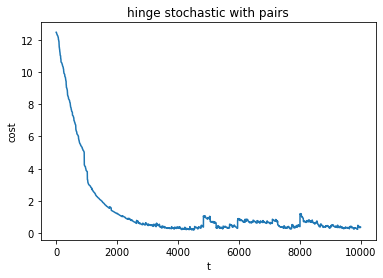

Nb de valeurs propres de M égales à 0:  52 / 64


In [162]:
n_features = X.shape[1]

# gamma (base value is 0.002)
gamma = 0.002
# regularisation delta
delta = 0.1

M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_reg(X, y, gamma, 0.0, 10000, 1000, M_ini, delta)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M égales à 0: ", np.sum(e < 1e-12), "/", e.shape[0])

## Approche basée sur les triplets

### Question 8

Donner ici l'interprétation de la fonction de perte.

On veut que la distance entre xi et xj soit plus petite que la distance entre xi et xk. Si c'est le cas, alors la perte sera inférieure à 1, et égale à 0 si la différence entre les distances est supéreieure à 1.

### Question 9

Implémenter et expérimenter avec une version triplet de l'algorithme en complétant la fonction `sgd_metric_learning_triplets` ci-dessous. Vous n'avez qu'à ajouter le calcul du sous-gradient de la perte sur le triplet tiré aléatoirement.

Le sous-gradient est égal à:

0 si 1 - d2M(xi,xk) + d2M(xi,xj) < 0

-(xi-xk)(xi-xk)T + (xi-xj)(xi-xj)T sinon

In [163]:
def hinge_loss_triplets(X, triplets_idx, M):
    """Calcul du hinge loss sur les triplets
    """
    diffp = X[triplets_idx[:, 0], :] - X[triplets_idx[:, 1], :]
    diffn = X[triplets_idx[:, 0], :] - X[triplets_idx[:, 2], :]
    return np.maximum(0., 1. - np.sum(np.dot(M, diffn.T) * diffn.T, axis=0) +
                      np.sum(np.dot(M, diffp.T) * diffp.T, axis=0))


def generate_triplets(X, y, n_triplets, random_state=42):
    """Generation de triplets
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    triplets_idx = np.zeros((n_triplets, 3), dtype=int)
    triplets_idx[:, 0] = rng.randint(0, n_samples, (n_triplets,))
    for i in range(n_triplets):
        same_idx = np.where(y == y[triplets_idx[i, 0]])[0]
        diff_idx = np.where(y != y[triplets_idx[i, 0]])[0]
        triplets_idx[i, 1] = same_idx[rng.randint(0, same_idx.shape[0])]
        triplets_idx[i, 2] = diff_idx[rng.randint(0, diff_idx.shape[0])]
    return triplets_idx


def sgd_metric_learning_triplets(X, y, gamma, alpha, n_iter, n_eval, M_ini,
                                 random_state=42):
    """Stochastic gradient algorithm for metric learning with triplets

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of triplets to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape
    # generate n_eval triplets
    triplets_idx = generate_triplets(X, y, n_eval, random_state=random_state)
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_triplets(X, triplets_idx, M))
        gradient = np.zeros((n_features, n_features))

        # tirer 1 triplet
        triplet_for_gradient = generate_triplets(X, y, 1, random_state=random_state + t)[0]

        # TODO QUESTION 9
        xi = X[triplet_for_gradient[0]]
        xj = X[triplet_for_gradient[1]]
        xk = X[triplet_for_gradient[2]]
        xi_xk = xi - xk
        xi_xj = xi - xj
        if 1 - np.dot(np.dot(xi_xk, M), xi_xk) + np.dot(np.dot(xi_xj, M), xi_xj) > 0:
            gradient = -np.outer(xi_xk, xi_xk) + np.outer(xi_xj, xi_xj)
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
    return M, pobj


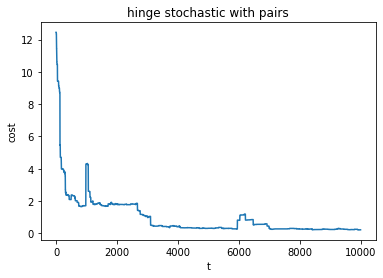

Nb de valeurs propres de M égales à 0:  1 / 64


In [164]:
n_features = X.shape[1]

# gamma (base value is 0.002)
gamma = 0.002

M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_triplets(X, y, gamma, 0.0, 10000, 1000, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M égales à 0: ", np.sum(e < 1e-12), "/", e.shape[0])

AUC with Euclidian is 0.7870587970079002
AUC with M is 0.978426561128541


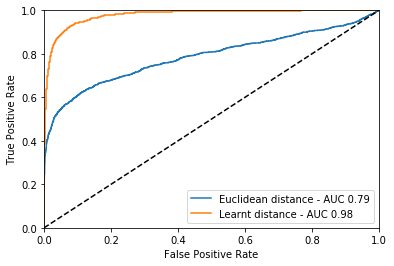

In [165]:
# on tire 10000 paires aleatoires et on calcule les distances
y_pairs, dist_euc, dist_M = distances_random_pairs(X, y, M, n_pairs=10000)

# tracer les courbes ROC
from sklearn.metrics import roc_curve, auc
# TODO QUESTION 5


fpr_euc, tpr_euc, _ = roc_curve(y_pairs, -dist_euc)
fpr_M, tpr_M, _ = roc_curve(y_pairs, -dist_M)

auc_euc = auc(fpr_euc, tpr_euc)
auc_M = auc(fpr_M, tpr_M)
# print area under curve
print("AUC with Euclidian is " + str(auc_euc))
print("AUC with M is " + str(auc_M))

# plot ROC curves

plt.figure()
plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()